In [5]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict


In [6]:
def load_graph(path):
    return nx.read_edgelist(path, nodetype=int)

G_ba = load_graph("data/ba.txt")
G_er = load_graph("data/er.txt")

print(G_ba.number_of_nodes(), G_ba.number_of_edges())
print(G_er.number_of_nodes(), G_er.number_of_edges())


1000 3990
999 4000


In [7]:
def vaccinate_random(G, k):
    return random.sample(list(G.nodes()), k)

def vaccinate_high_degree(G, k):
    degree_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
    return [node for node, _ in degree_sorted[:k]]

def vaccinate_high_betweenness(G, k):
    bc = nx.betweenness_centrality(G)
    sorted_nodes = sorted(bc.items(), key=lambda x: x[1], reverse=True)
    return [node for node, _ in sorted_nodes[:k]]


In [ ]:
def sir_simulation(G, vaccinated, beta=0.04, gamma=0.2, time_period=1000):
    # states: 0-S, 1-I, 2-R
    # initalizating all as S
    state = {node: 0 for node in G.nodes()}
    
    #vaccinate the chosen nodes
    for v in vaccinated:
        state[v] = 2
    
    #choosing patient zero from the unvaccinated nodes
    susceptible_nodes = [n for n in G.nodes() if state[n] == 0]
    patient_zero = random.choice(susceptible_nodes)
    state[patient_zero] = 1

    infected_counts = []

    #over time infection spreads
    for _ in range(time_period):
        
        new_state = state.copy()
        infected_now = [n for n in G.nodes() if state[n] == 1]
        infected_counts.append(len(infected_now))
        
        #if no infected the pandemic ends
        if len(infected_now) == 0:
            break

        for node in infected_now:
            # Try to infect neighbors
            for nbr in G.neighbors(node):
                if state[nbr] == 0 and random.random() < beta:
                    new_state[nbr] = 1

            # Recovery
            if random.random() < gamma:
                new_state[node] = 2

        state = new_state

    return infected_counts


In [9]:
def run_experiment(G, k, strategy_fn, runs=100):
    final_sizes = []
    
    for _ in range(runs):
        vaccinated = strategy_fn(G, k)
        infected_curve = sir_simulation(G, vaccinated)
        final_sizes.append(sum(infected_curve))  # cumulative infection proxy
    
    return np.mean(final_sizes)


In [10]:
k = 50
runs = 100

results = defaultdict(dict)

for name, G in [("BA", G_ba), ("ER", G_er)]:
    results[name]["Random"] = run_experiment(G, k, vaccinate_random, runs)
    results[name]["Degree"] = run_experiment(G, k, vaccinate_high_degree, runs)
    results[name]["Betweenness"] = run_experiment(G, k, vaccinate_high_betweenness, runs)

results


defaultdict(dict,
            {'BA': {'Random': 817.53, 'Degree': 6.13, 'Betweenness': 8.82},
             'ER': {'Random': 514.07, 'Degree': 313.7, 'Betweenness': 260.02}})

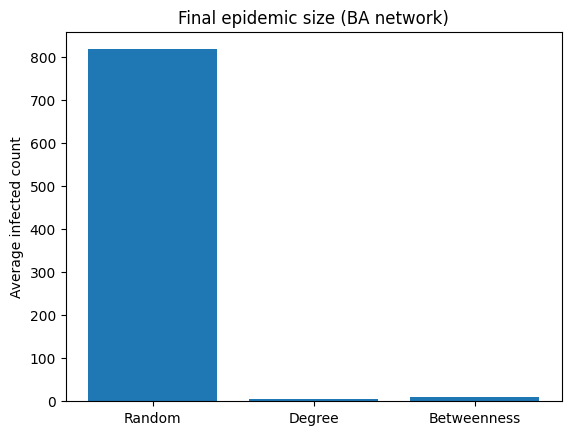

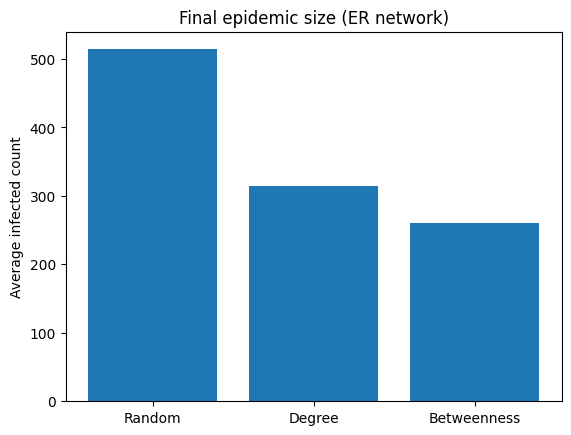

In [11]:
labels = ["Random", "Degree", "Betweenness"]

for net in results:
    values = [results[net][l] for l in labels]
    plt.figure()
    plt.bar(labels, values)
    plt.title(f"Final epidemic size ({net} network)")
    plt.ylabel("Average infected count")
    plt.show()
